1. Load the MNIST dataset into train and test data loaders. Use the same
parameters and apply the same transformations like described in the blog
post.

In [1]:
import torch
import torchvision

n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False # completely deactives cuDNN
torch.manual_seed(random_seed) # sets the random number generator to seed = 1

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/jankozirkelbach/Documents/KI-Lab/Assignment01', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/jankozirkelbach/Documents/KI-Lab/Assignment01', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

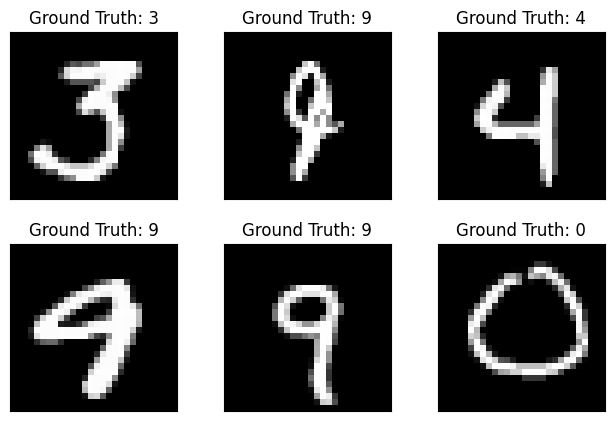

In [2]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

2. Create a feedforward neural network consisting of an input layer, one hidden
layer of size 100 and an output layer (same structure as in 0_Simple_NN.py).
For training on the MNIST dataset you need to change the following:
- Adjust the size of the input layer to be able to take in the MNIST data (hint:
you must adjust the tensor format from the MNIST data into a flat structure).
- Use log_softmax as activation function for the output layer (as in the blog).
Note: Do not use a CNN like they do in the blog post! Use Relu as activation
function for the hidden layer.

In [3]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    # keeps the batch size and flattens all remaining dimensions into a single long vector 
    # Example: turns [N, 1, 28, 28] into [N, 784].
    x = torch.flatten(x, start_dim=1)

    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return torch.log_softmax(y_pred, dim=1)

# D_in is input dimension; H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 784, 100, 10

3. Train your network on the training data for 50 epochs using the negative log
likelihood loss (like in the blog). Create a plot of the training loss (like in the blog but
without the test loss).

In [4]:
import torch.nn.functional as F
network = TwoLayerNet(D_in, H, D_out)
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

train_losses = []
train_counter = []
test_losses = []

def train(epoch):
    network.train() 
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346312
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.061338
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.787498
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.563534
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.323617
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.157442
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.067432
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.896387
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.772468
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.583144
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.607685
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.453165
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.664993
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.581345
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.789183
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.552753
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.481114
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.365733
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.468975
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.505924
Train Epoch: 1 [12800/60000 (

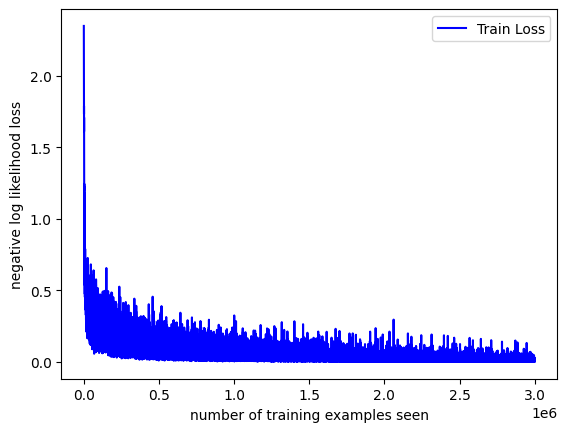

In [5]:
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

4. Test the network on the MNIST test data and give out accuracy and loss.

In [7]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
test()

/Users/jankozirkelbach/.pyenv/versions/3.13.7/lib/python3.13/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0685, Accuracy: 9801/10000 (98%)



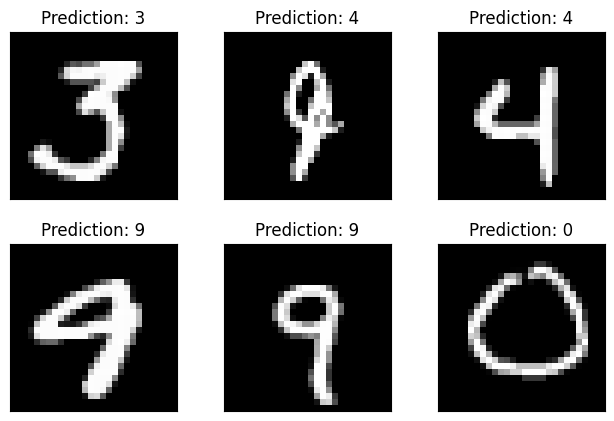

In [8]:
with torch.no_grad():
  output = network(example_data)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

5. Find out how the model can be trained on the GPU instead of the CPU. Compare the
training time between CPU and GPU. (Note: Do not expect too much improvement
on this small data set).

In [9]:
import time

# 1. Detect device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA available – training on NVIDIA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS available – training on Apple GPU")
else:
    device = torch.device("cpu")
    print("No GPU found – training on CPU")

# Function to train once on a given device
def train_on_device(device, epochs):
    global network, optimizer  # reinitialize model and optimizer

    # Create model and optimizer on the selected device
    network = TwoLayerNet(D_in, H, D_out).to(device)
    optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

    start_time = time.time()

    for epoch in range(1, epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data to the device
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )

    end_time = time.time()
    return end_time - start_time

# 2. Training time on GPU (if available)
gpu_time = None
if device.type != "cpu":
    gpu_time = train_on_device(device, n_epochs)

# 3. Training time on CPU
cpu_device = torch.device("cpu")
cpu_time = train_on_device(cpu_device, n_epochs)

# 4. Print comparison
print("\n========== Training Time Comparison ==========")
if gpu_time is not None:
    print(f"GPU ({device}): {gpu_time:.2f} seconds")
print(f"CPU: {cpu_time:.2f} seconds")

if gpu_time is not None:
    speedup = cpu_time / gpu_time
    print(f"Speedup: {speedup:.2f}x faster on GPU" if speedup > 1 else "No speedup detected.")
else:
    print("No GPU available – only CPU tested.")

MPS available – training on Apple GPU

========== Training Time Comparison ==========
GPU (mps): 390.77 seconds
CPU: 151.25 seconds
No speedup detected.
